This notebook analyzes the fits file 'snapshot_150_spec_total.fits' and creates RGB plots.

## Imports

In [26]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import astropy.units as u
import numpy.ma as ma
from astropy.visualization import make_lupton_rgb
from astropy.convolution import convolve, Gaussian2DKernel

## Load in the fits file

This section loads in and examines the header of the fits file.

In [2]:
spec_file = 'snapshot_150_spec_total.fits'

In [3]:
with fits.open(spec_file) as hdul:
    spec_data = hdul[0].data
    print(f"SPECS data shape: {spec_data.shape}")
    spec_header = hdul[0].header
    for card in spec_header.cards:
            print(card)

SPECS data shape: (100, 800, 800)
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  800 / length of data axis 1                          
NAXIS2  =                  800 / length of data axis 2                          
NAXIS3  =                  100 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BSCALE  =                    1 / Array value scale                              
BZERO   =                    0 / Array value offset                             
DATE    = '2025-07-16T19:22:20' / Date and time of creation (UTC)          

## Examine wavelength ranges

This section loads in the 'snapshot_120_spec_sed.dat' to examine the 100 randomized wavelengths between the ranges 0.3-30 microns. The wavelengths are saved to an array. I defined the ranges for the wavelengths to be the following: blue wavelengths from 0.3-1 micron, green wavelengths from 2-5 micron, and red wavelengths from 10-25 micron. These ranges are saved in a dictionary 'wavelength_ranges'. A new dictionary is created, 'color_band_indicies', which will be filled by the indices of wv_arr that fall within the wavelength_ranges. I then examine the ratio of the number of pixels in each band that is less than/equal to 0 compared to the total number of pixels in each band. 

In [4]:
sed = np.genfromtxt('snapshot_150_spec_sed.dat')
wv_arr = sed[:,0]
wv_arr

array([ 0.3       ,  0.31428473,  0.32924963,  0.3449271 ,  0.36135106,
        0.37855706,  0.39658234,  0.41546591,  0.43524863,  0.45597332,
        0.47768484,  0.50043016,  0.52425852,  0.54922148,  0.57537308,
        0.6027699 ,  0.63147124,  0.66153922,  0.69303891,  0.72603848,
        0.76060935,  0.79682633,  0.83476782,  0.87451592,  0.91615665,
        0.95978014,  1.00548079,  1.05335752,  1.10351393,  1.15605858,
        1.21110518,  1.26877286,  1.32918644,  1.39247665,  1.45878047,
        1.5282414 ,  1.60100977,  1.67724305,  1.75710624,  1.84077218,
        1.92842194,  2.0202452 ,  2.11644069,  2.21721661,  2.32279105,
        2.43339249,  2.54926031,  2.67064526,  2.79781004,  2.93102987,
        3.07059307,  3.21680167,  3.3699721 ,  3.53043586,  3.69854022,
        3.87464899,  4.05914332,  4.25242249,  4.45490479,  4.66702843,
        4.8892525 ,  5.12205794,  5.36594859,  5.62145227,  5.88912195,
        6.16953693,  6.46330407,  6.77105916,  7.09346824,  7.43

In [5]:
wavelength_ranges = {
    "Blue": (0.3, 1),
    "Green": (2, 5),
    "Red": (10, 25)
}

In [6]:
color_band_indices = {}

for color_name, (min_wv, max_wv) in wavelength_ranges.items():
    indices = np.where((wv_arr >= min_wv) & (wv_arr <= max_wv))[0]
    color_band_indices[color_name] = indices
    print(f"Indices for {color_name} band: {indices}")

Indices for Blue band: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Indices for Green band: [41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]
Indices for Red band: [76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]


In [7]:
for color_name, indices in color_band_indices.items():
    print(f"--- Analyzing {color_name} band ---")

    band_images = spec_data[indices, :, :]

    band_combined = np.sum(band_images, axis=0)

    nx, ny = band_combined.shape
    n_pixs = nx * ny

    zero_or_less_pixels = len(np.where(band_combined <= 0)[0])

    ratio = zero_or_less_pixels / n_pixs

    print(f"Total pixels for {color_name}: {n_pixs}")
    print(f"Pixels <= 0 for {color_name}: {zero_or_less_pixels}")
    print(f"Ratio of pixels <= 0 for {color_name}: {ratio:.4f}\n")

--- Analyzing Blue band ---
Total pixels for Blue: 640000
Pixels <= 0 for Blue: 634205
Ratio of pixels <= 0 for Blue: 0.9909

--- Analyzing Green band ---
Total pixels for Green: 640000
Pixels <= 0 for Green: 476585
Ratio of pixels <= 0 for Green: 0.7447

--- Analyzing Red band ---
Total pixels for Red: 640000
Pixels <= 0 for Red: 172989
Ratio of pixels <= 0 for Red: 0.2703



## RGB Plot

In [8]:
np_function = {
    'log10': np.log10,
    'sinh': np.sinh,
    'tanh': np.tanh,
    'sqrt': np.sqrt
}

In [24]:
def rgb_plot(spec_data, color_band_indices, func_name='log10'):
    '''
    '''
    if func_name not in np_function:
        print(f'Error: Function {func_name} not found in np_function dictionary.')
        print(f'Available functions are: {list(np_function.keys())}')
        return

    func = np_function[func_name]

    fig_hist, axes_hist = plt.subplots(1, 3, figsize=(18,6))
    fig_pcolormesh, axes_pcolormesh = plt.subplots(1, 3, figsize=(24,8))
    fig_rgb, ax_rgb = plt.subplots(1, 1, figsize=(10,10))

    fig_hist.suptitle(f'Histograms of {func_name} Data', fontsize=16)
    fig_pcolormesh.suptitle(f'{func_name} Data (pcolormesh)', fontsize=16)
    fig_rgb.suptitle(f'RGB Image ({func_name} applied)', fontsize=16)

    rgb_data_for_lupton = {}

    for i, (color_name, indices) in enumerate(color_band_indices.items()):
        print(f"\n--- Processing {color_name} band with {func_name} ---")
        band_images = spec_data[indices, :, :]
        band_combined = np.sum(band_images, axis=0)

        masked_data = ma.masked_invalid(band_combined)
        masked_data = ma.masked_where(masked_data <= 1e-10, masked_data)

        processed_data = func(masked_data)
        processed_data = ma.masked_invalid(processed_data)

        rgb_data_for_lupton[color_name] = processed_data

        print(f"Min value for {color_name} band ({func_name}): {np.min(processed_data):.2e}")
        print(f"Max value for {color_name} band ({func_name}): {np.max(processed_data):.2e}")

        # calculating vmin and vmax by using percentiles
        valid_data = processed_data.compressed()
        
        lower_percentile = 0.5
        upper_percentile = 99.5

        vmin = np.percentile(valid_data, lower_percentile)
        vmax = np.percentile(valid_data, upper_percentile)

        # hist
        axes_hist[i].hist(processed_data.compressed(), bins=50, color=color_name)
        axes_hist[i].set_title(f'{color_name} Band Histogram')
        axes_hist[i].set_xlabel(f'{func_name} Value')
        axes_hist[i].set_ylabel('Frequency')

        # pcolormesh
        im = axes_pcolormesh[i].pcolormesh(processed_data, cmap=f'{color_name}s', shading='auto',
                                          vmin=vmin, vmax=vmax)
        axes_pcolormesh[i].set_title(f'{color_name} Band {func_name} Image')
        axes_pcolormesh[i].set_xlabel('X Pixels')
        axes_pcolormesh[i].set_ylabel('Y Pixels')
        fig_pcolormesh.colorbar(im, ax=axes_pcolormesh[i])

    #RGB image
    rgb_image = make_lupton_rgb(
        rgb_data_for_lupton['Red'].filled(0),
        rgb_data_for_lupton['Green'].filled(0),
        rgb_data_for_lupton['Blue'].filled(0),
        Q=8,
        stretch=0.5
    )

    ax_rgb.imshow(rgb_image, origin='lower')
    ax_rgb.set_title('RGB Image')
    ax_rgb.set_xlabel('X Pixels')
    ax_rgb.set_ylabel('Y Pixels')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    hist_fname = f'{func_name}_histograms.png'
    pcolormesh_fname = f'{func_name}_pcolormesh.png'
    rgb_fname = f'{func_name}_rgb.png'

    fig_hist.savefig(hist_fname)
    fig_pcolormesh.savefig(pcolormesh_fname)
    fig_rgb.savefig(rgb_fname)

    plt.close(fig_hist)
    plt.close(fig_pcolormesh)
    plt.close(fig_rgb)


--- Processing Blue band with log10 ---


/tmp/ipykernel_100/696073096.py:29: RuntimeWarning: divide by zero encountered in log10
  processed_data = func(masked_data)


Min value for Blue band (log10): -1.00e+01
Max value for Blue band (log10): -1.39e+00

--- Processing Green band with log10 ---
Min value for Green band (log10): -1.00e+01
Max value for Green band (log10): 2.73e+00

--- Processing Red band with log10 ---
Min value for Red band (log10): -1.00e+01
Max value for Red band (log10): 6.41e+00


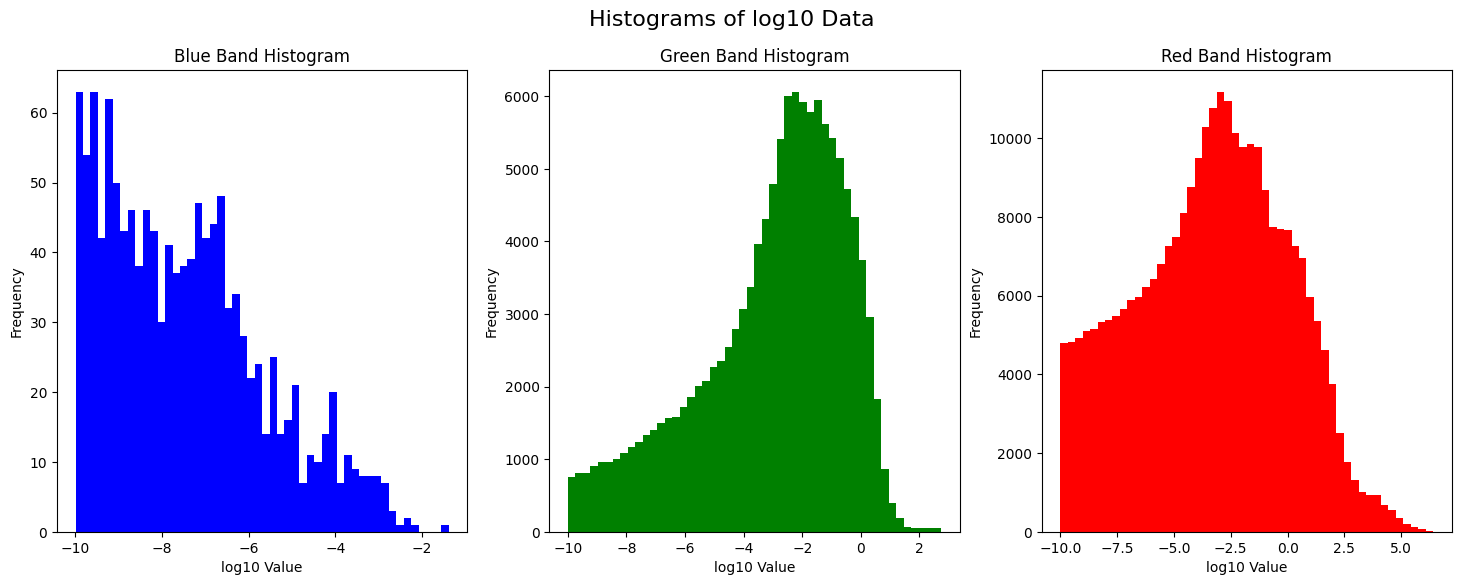

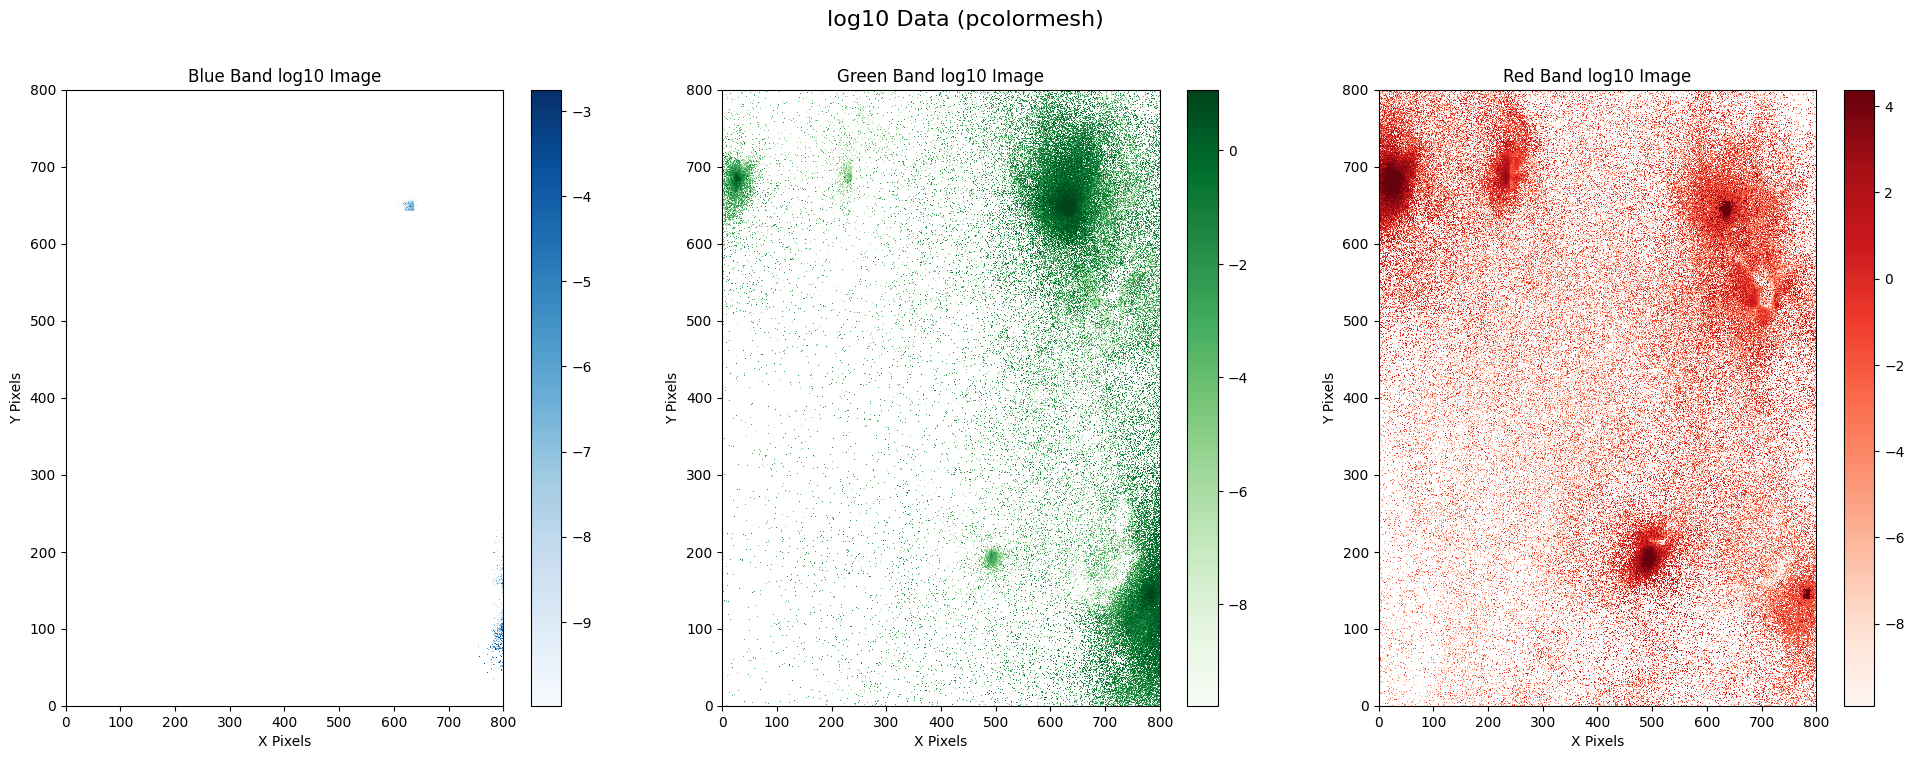

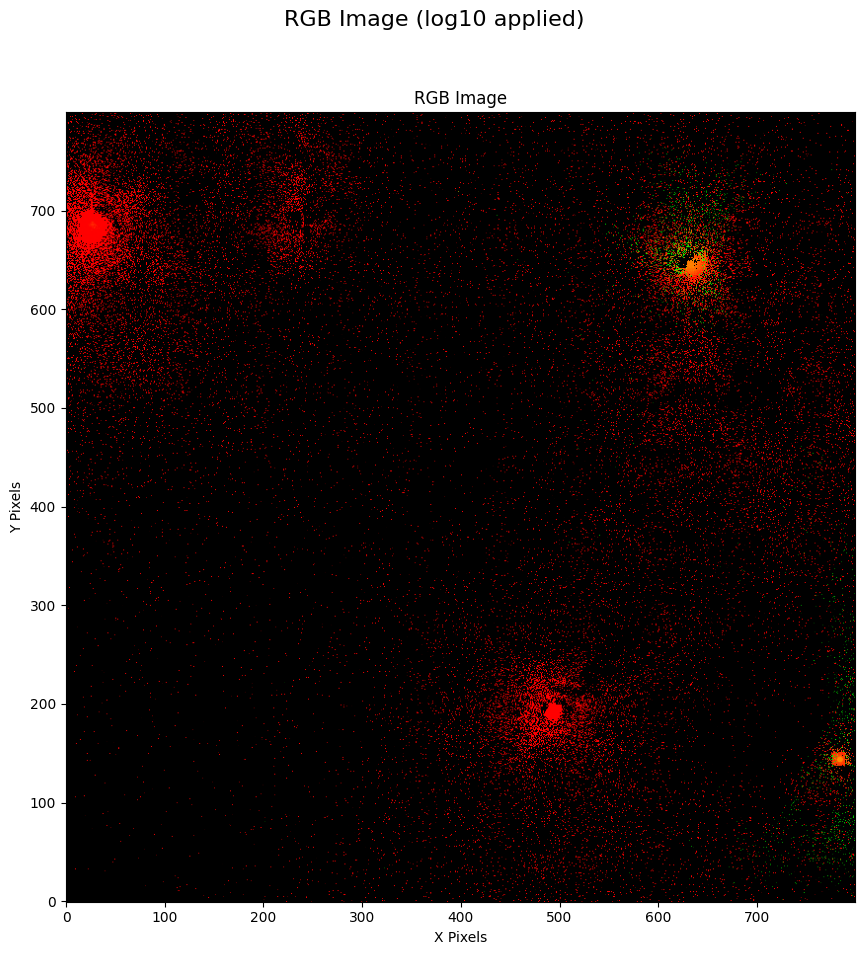

In [25]:
rgb_plot(spec_data, color_band_indices, func_name='log10')


--- Processing Blue band with sinh ---
Min value for Blue band (sinh): 1.01e-10
Max value for Blue band (sinh): 4.09e-02

--- Processing Green band with sinh ---
Min value for Green band (sinh): 1.00e-10
Max value for Green band (sinh): 1.08e+38


/tmp/ipykernel_100/2161760276.py:29: RuntimeWarning: overflow encountered in sinh
  processed_data = func(masked_data)



--- Processing Red band with sinh ---
Min value for Red band (sinh): 1.00e-10
Max value for Red band (sinh): 3.35e+38


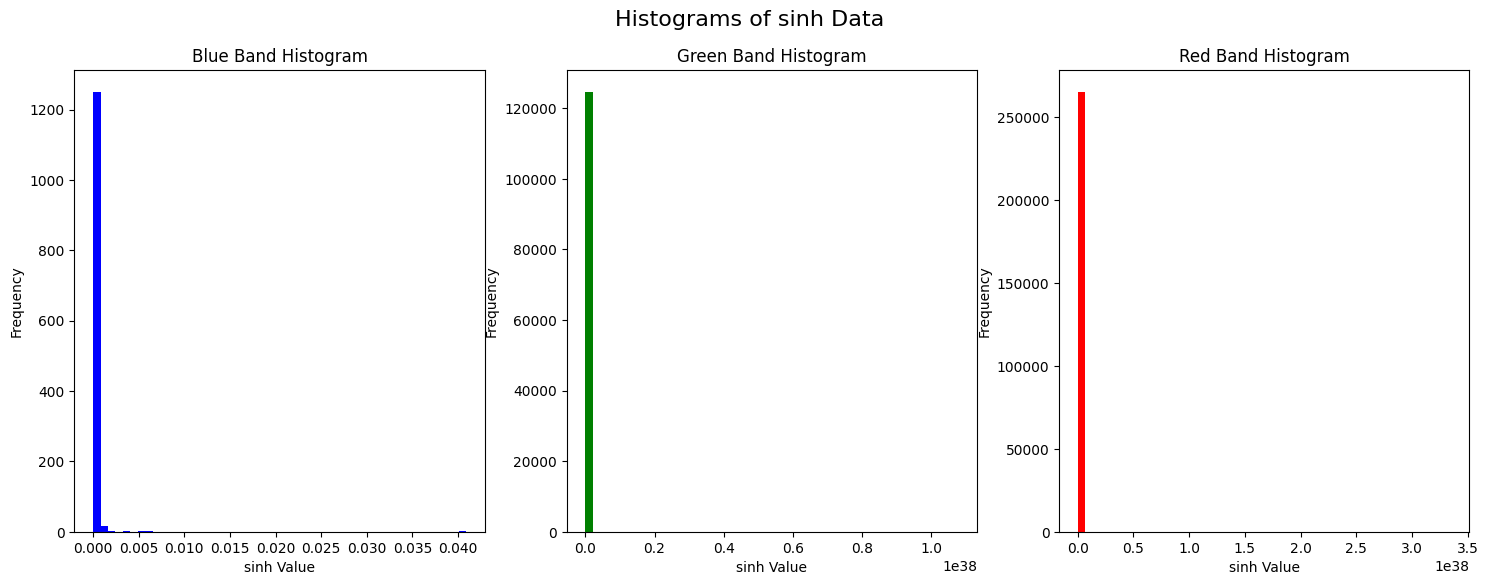

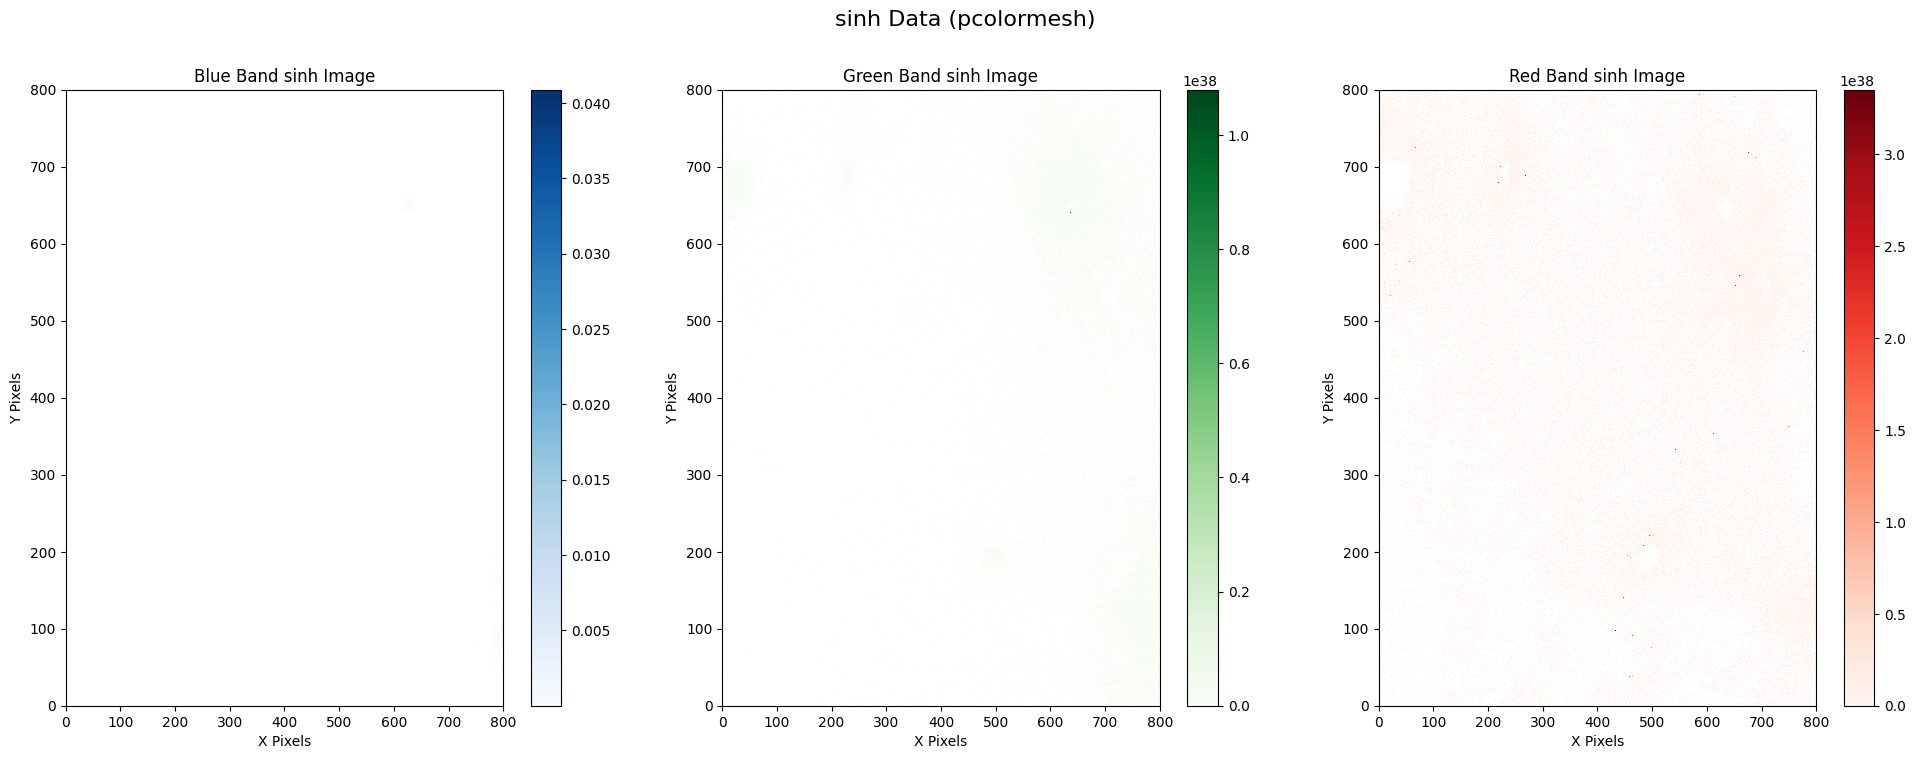

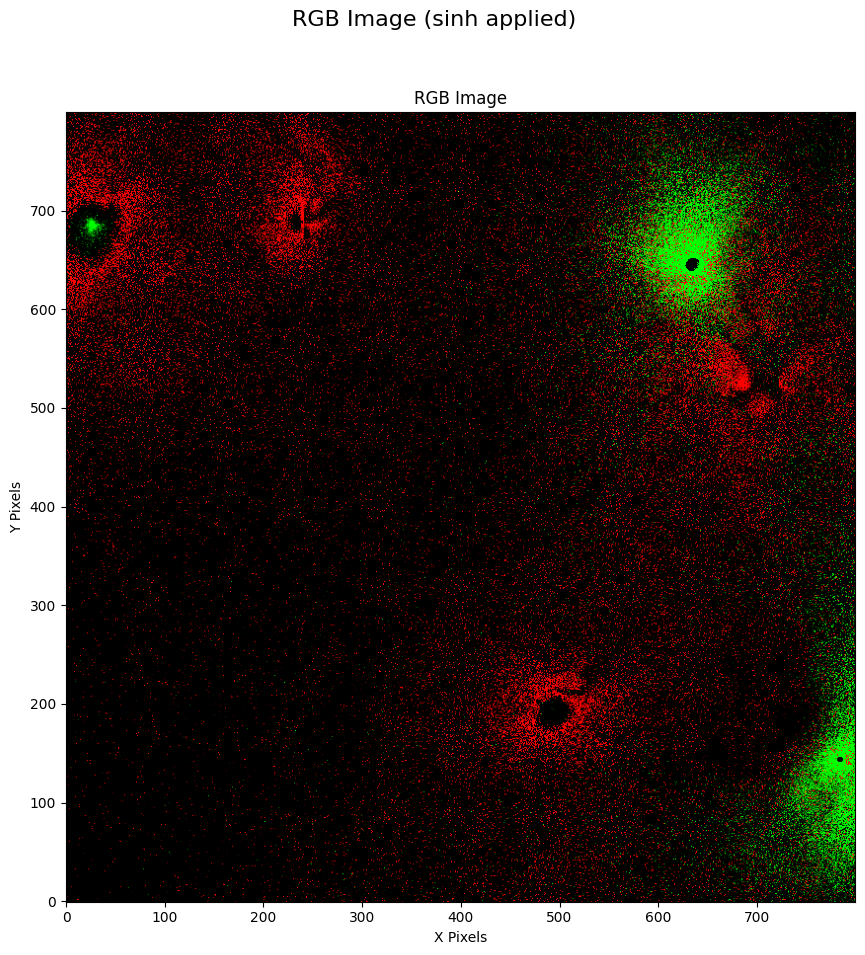

In [21]:
rgb_plot(spec_data, color_band_indices, func_name='sinh')


--- Processing Blue band with tanh ---
Min value for Blue band (tanh): 1.01e-10
Max value for Blue band (tanh): 4.08e-02

--- Processing Green band with tanh ---
Min value for Green band (tanh): 1.00e-10
Max value for Green band (tanh): 1.00e+00

--- Processing Red band with tanh ---
Min value for Red band (tanh): 1.00e-10
Max value for Red band (tanh): 1.00e+00


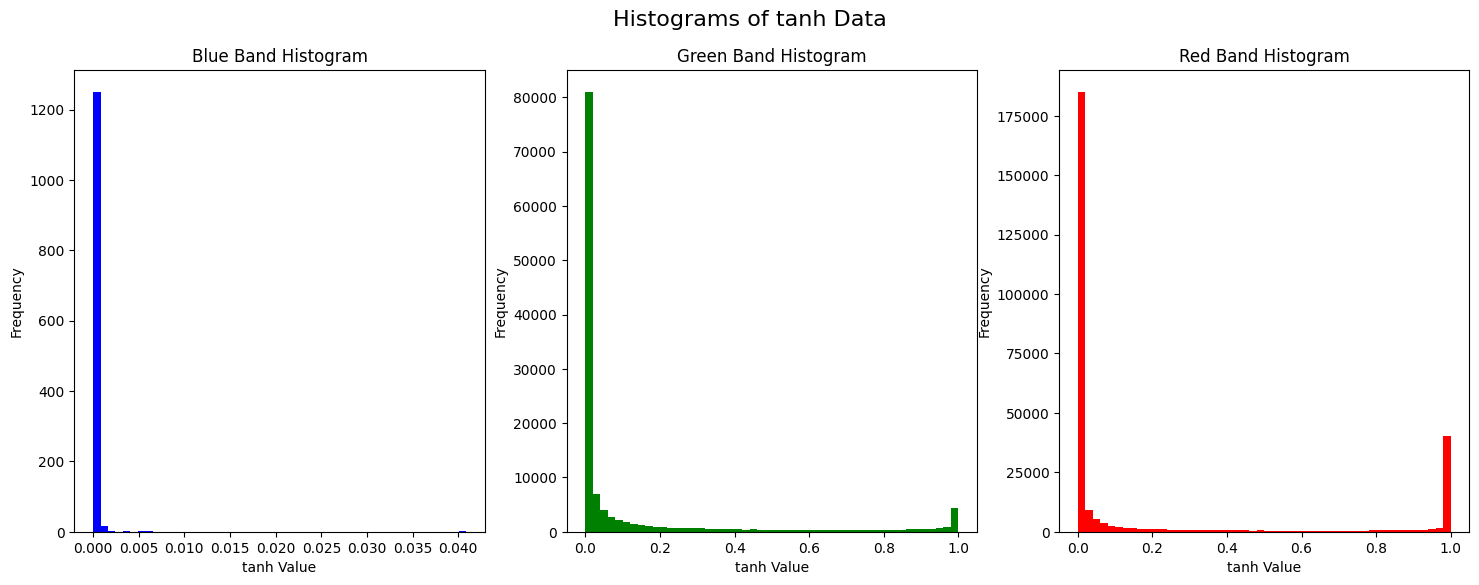

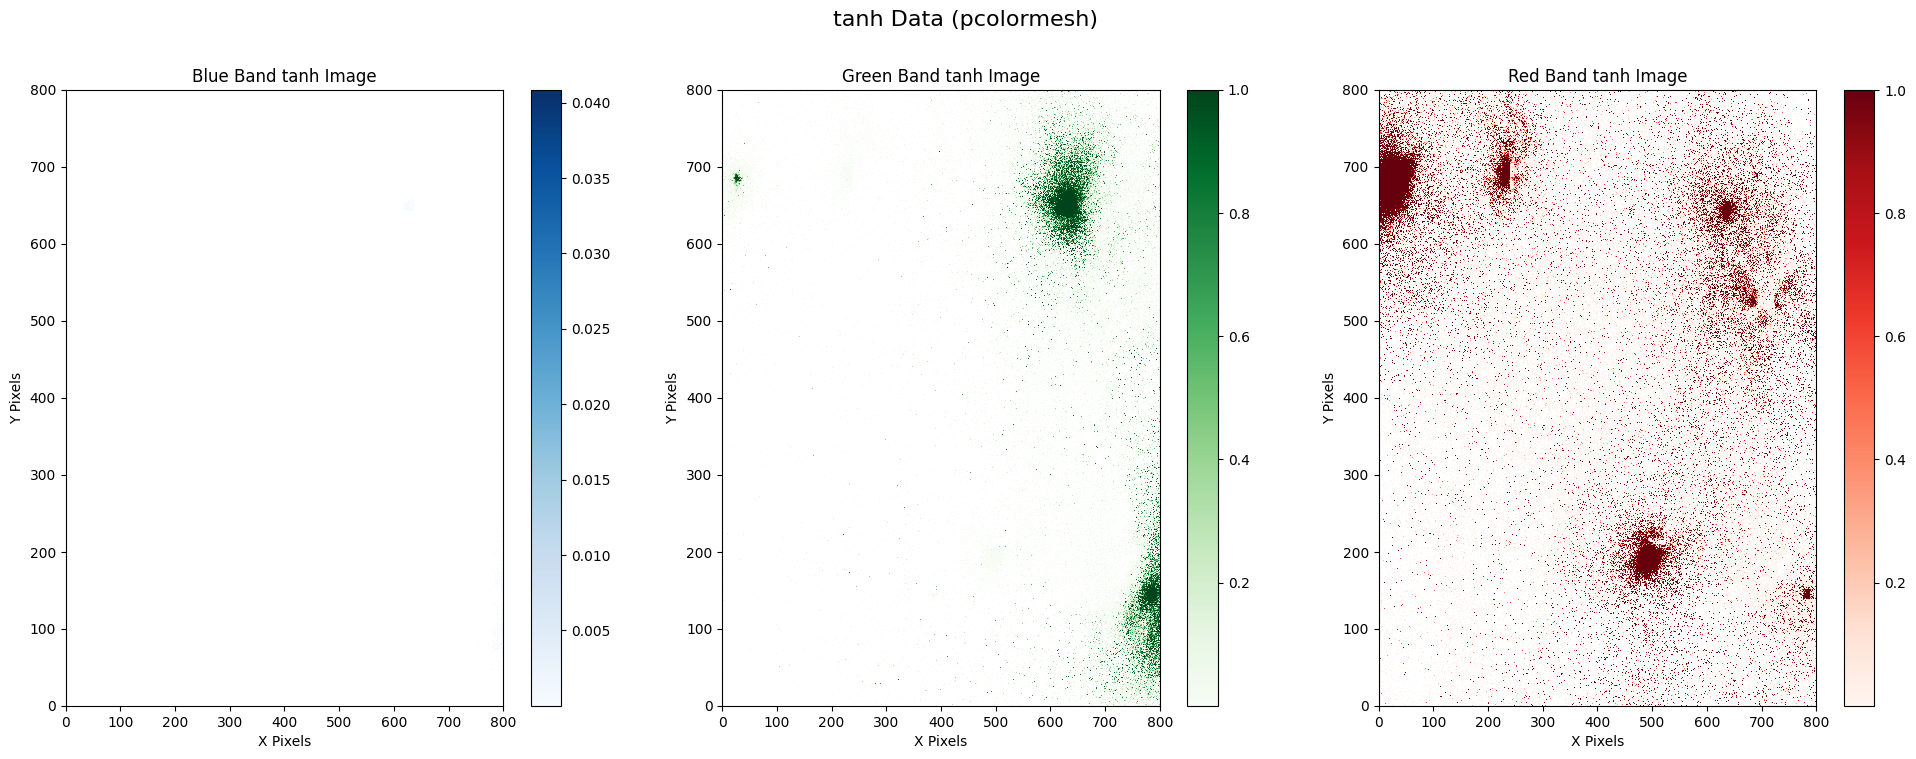

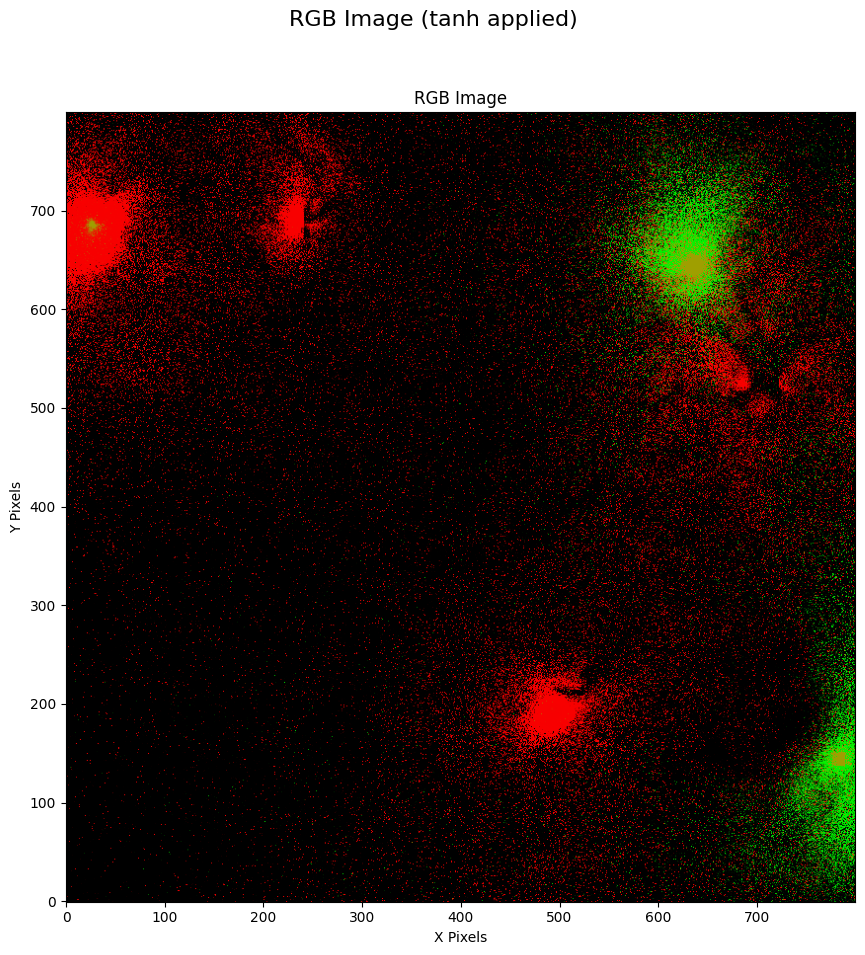

In [22]:
rgb_plot(spec_data, color_band_indices, func_name='tanh')


--- Processing Blue band with sqrt ---
Min value for Blue band (sqrt): 1.00e-05
Max value for Blue band (sqrt): 2.02e-01

--- Processing Green band with sqrt ---
Min value for Green band (sqrt): 1.00e-05
Max value for Green band (sqrt): 2.32e+01

--- Processing Red band with sqrt ---
Min value for Red band (sqrt): 1.00e-05
Max value for Red band (sqrt): 1.60e+03


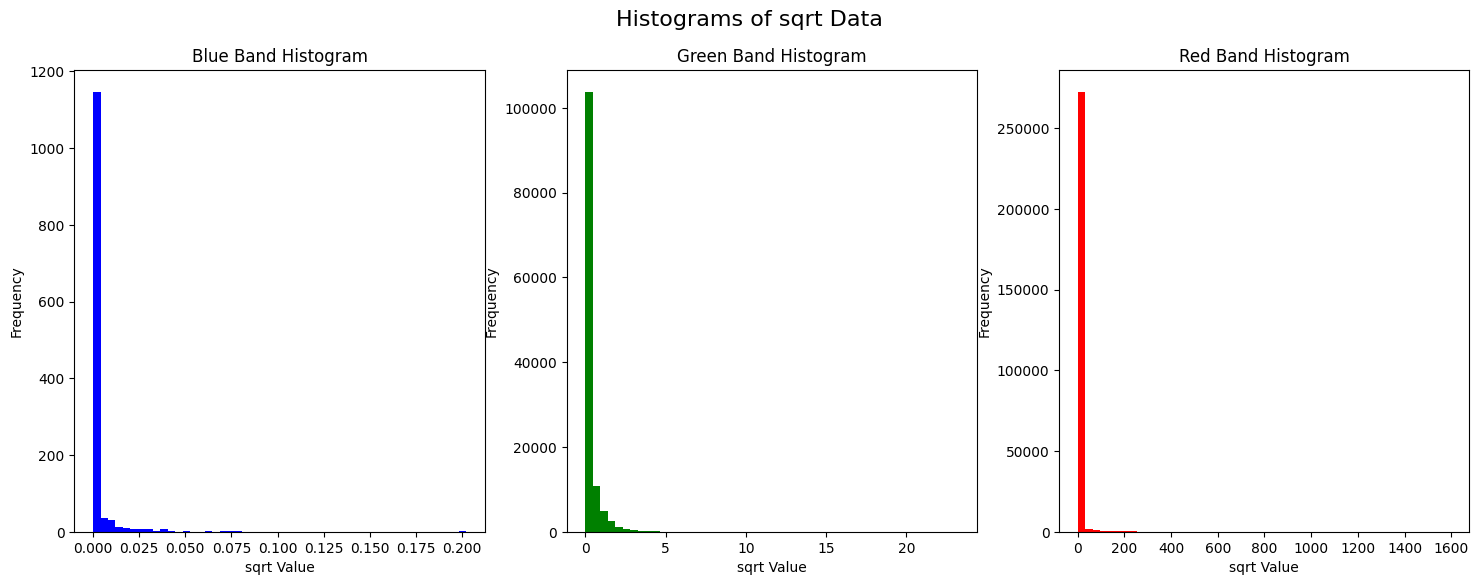

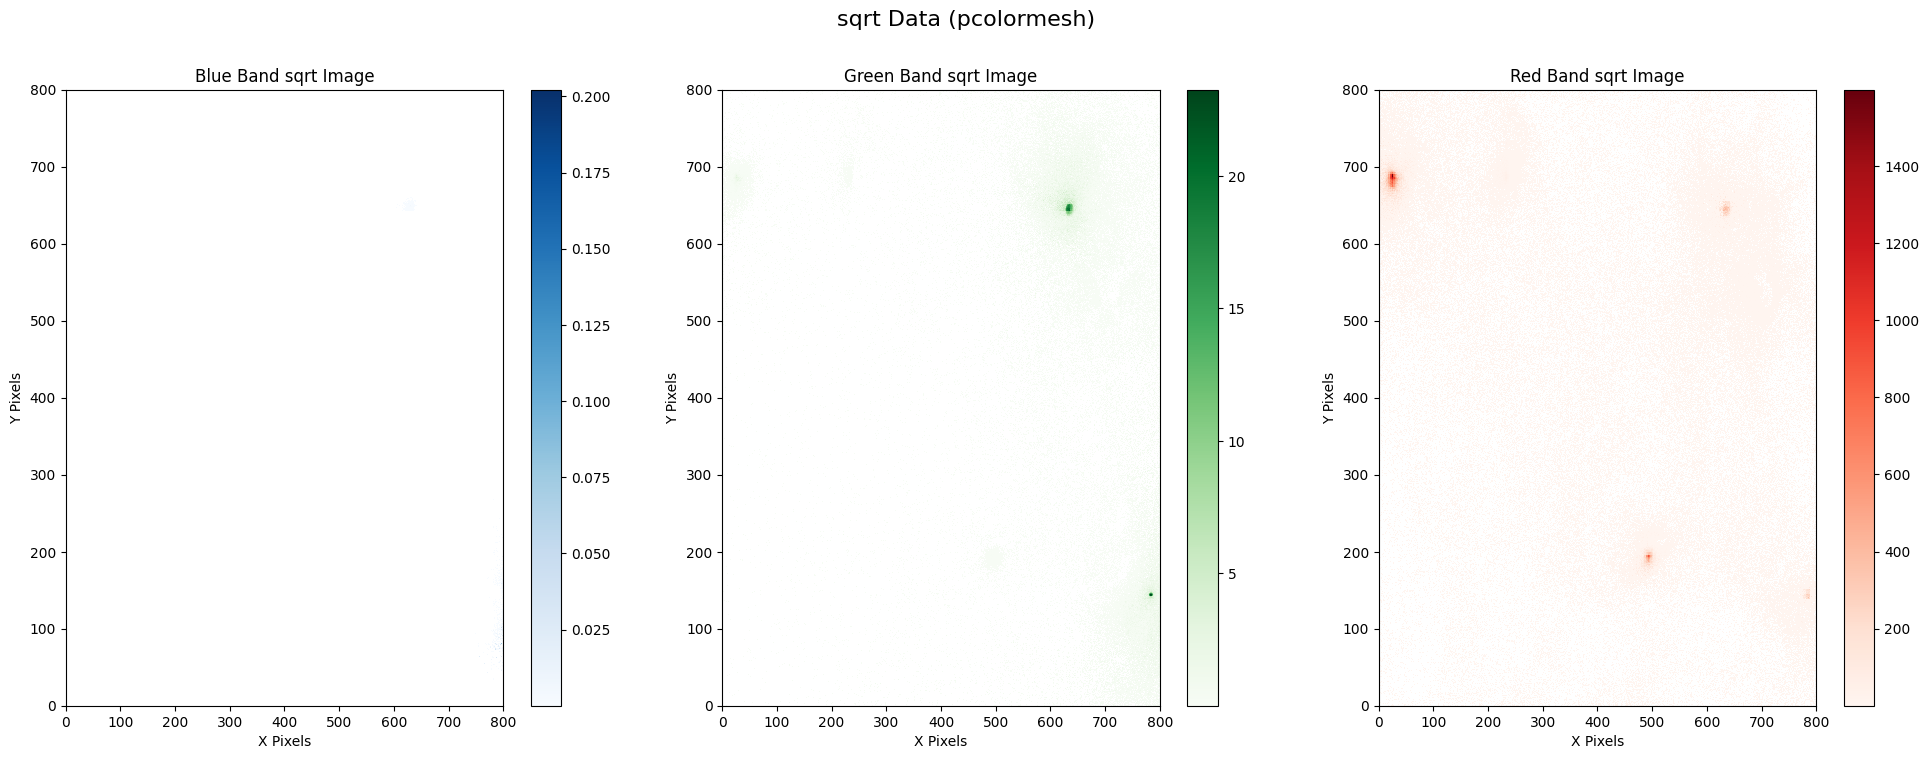

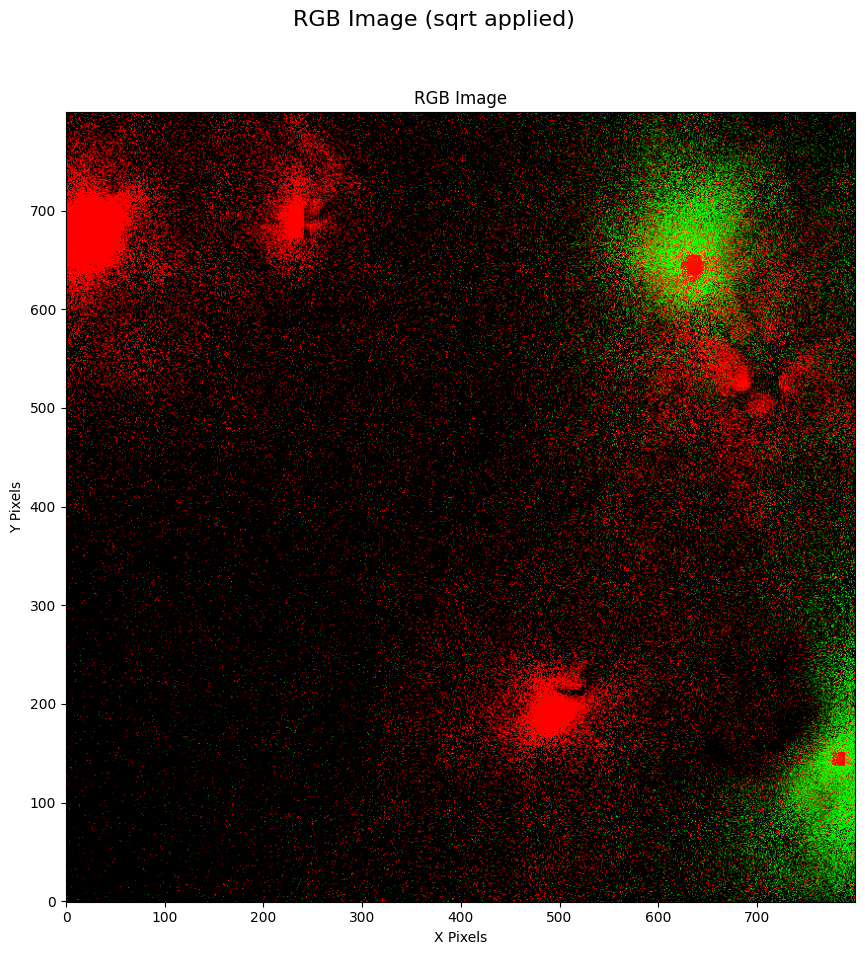

In [23]:
rgb_plot(spec_data, color_band_indices, func_name='sqrt')